In [1]:
# Notebook to search Cheminventory DB (as excel file)
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
from itertools import product
import numpy as np

In [2]:
# read in ChemInventory excel file
chem_inv = pd.read_excel('/home/warren/XChem_projects/xchem-CovidOT/in_data/InventoryExport.xlsx')

In [3]:
chem_inv.head()

,Container Name,Substance CAS,Container Size,Unit,Barcode,Supplier,Comments,Location,Date Acquired,SMILES,Molecular Weight,Molecular Formula
0,"(1S,4S)-2,5-diazabicyclo[2.2.1]heptane dihydro...",5260-20-8,100.2,mg,EN300-343647,Enamine,C7,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,C1[C@H]2CN[C@@H]1CN2.Cl.Cl,171.07,C5H12Cl2N2
1,(2-Biphenyl)di-tert-butylphosphine (JohnPhos),24311-51-7,1,g,NaN,Aldrich,NaN,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > So...,2017-05-24,C1=CC=CC(C2=CC=CC=C2)=C1P(C(C)(C)C)C(C)(C)C,298.41,C20H27P
2,(2-bromoethyl)benzene,103-63-9,1005.2,mg,EN300-96843,Enamine,E2,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,2018-02-01,C1=CC=C(C=C1)CCBr,185.06,C8H9Br
3,(2-chloro-6-fluorophenyl)methanamine,15205-15-9,1004.8,mg,EN300-33074,Enamine,A5,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,C1=CC(=C(C(=C1)Cl)CN)F,159.59,C7H7ClFN
4,"(2H-1,3-benzodioxol-5-yl)boronic acid",94839-07-3,1005.3,mg,EN300-212504,Enamine,B9,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,B(C1=CC2=C(C=C1)OCO2)(O)O,165.94,C7H7BO4


In [4]:
# Let's write a few functions to help with the search. We need to search the DF and identify
# compounds that mathc amide synthesis 

def getamidereacts(mols):
    """
    df: Input mols from ChemInventory
    
    out: This function will return lists of R-NH2 reacts, R-COOH and R-COCl reacts that
         can be used in an amide coupling rxn
    """

    RCOOH_patt = Chem.MolFromSmarts('[*;!#1;!-]-[A#6](=[#8])[#8][#1]')
    RCOCl_patt =  Chem.MolFromSmarts('[*]-[A#6](=[#8])[#17]')
    RNH2_patt =  Chem.MolFromSmarts('[*;!#16;!#1]-[A#7;!R;X3]([#1])([#1])')
    
    RCOOH_mols = [Chem.RemoveHs(mol) for mol in mols if mol.HasSubstructMatch(RCOOH_patt)]
    RCOOH_smi = set([Chem.MolToSmiles(mol) for mol in RCOOH_mols])
    RCOOH_mols = [Chem.MolFromSmiles(smi) for smi in RCOOH_smi]
    
    RCOCl_mols = [Chem.RemoveHs(mol) for mol in mols if mol.HasSubstructMatch(RCOCl_patt)]
    RCOCl_smi = set([Chem.MolToSmiles(mol) for mol in RCOCl_mols])
    RCOCl_mols = [Chem.MolFromSmiles(smi) for smi in RCOCl_smi]
    
    RNH2_mols = [Chem.RemoveHs(mol) for mol in mols if mol.HasSubstructMatch(RNH2_patt)]
    RNH2_smi = set([Chem.MolToSmiles(mol) for mol in RNH2_mols])
    RNH2_mols = [Chem.MolFromSmiles(smi) for smi in RNH2_smi]
    
    return RCOOH_mols, RCOCl_mols, RNH2_mols

def reactamide(RCOOH_mols, RCOCl_mols, RNH2_mols):
    """
    RCOOH_mols, RCOCl_mols, RNH2_mols: Input react mols from getamidesreacts func
    
    out: This function will return two lists of amide coupling products  
    """
    
    # Assign SMARTS reaction
    RCOOH_RNH2_reaction = rdChemReactions.ReactionFromSmarts('[#6:1](=[#8:2])-[#8].[A#7:3]>>[#6:1](=[#8:2])-[A#7:3]')
    # Get list of tuples of all possible pairwise reactants
    RCOOH_RNH2_reacts = list(product(RCOOH_mols, RNH2_mols))
    # Run the reaction for all the pairwise reactants found
    RCOOH_RNH2_prods = [RCOOH_RNH2_reaction.RunReactants((react[0],react[1]))[0][0] for react in RCOOH_RNH2_reacts] 
    
    # Do not include any None mols
    RCOOH_RNH2_prods = [mol for mol in RCOOH_RNH2_prods if mol is not None]
    
    # Assign SMARTS reaction
    RCOCl_RNH2_reaction = rdChemReactions.ReactionFromSmarts('[#6:1](=[#8:2])-[#17].[A#7:3]>>[#6:1](=[#8:2])-[A#7:3]')
    # Get list of tuples of all possible pairwise reactants
    RCOCl_RNH2_reacts = list(product(RCOCl_mols, RNH2_mols))
    # Run the reaction for all the pairwise reactants found
    RCOCl_RNH2_prods = [RCOCl_RNH2_reaction.RunReactants((react[0],react[1]))[0][0] for react in RCOCl_RNH2_reacts] 
    
    # Do not include any None mols
    RCOCl_RNH2_prods = [mol for mol in RCOCl_RNH2_prods if mol is not None]
    
    return RCOOH_RNH2_prods, RCOCl_RNH2_prods
    

In [5]:
# Get the mols from DB smiles
mols = [Chem.MolFromSmiles(smi) for smi in chem_inv.SMILES]
# Add H's to help with finding RCOOH and RNH2 compounds
mols_H = [Chem.AddHs(mol) for mol in mols if mol is not None]
# Use the getamidereacts function to find all RCOOH, RCOCl and RNH2 compounds
RCOOH_mols, RCOCl_mols, RNH2_mols = getamidereacts(mols_H)

In [6]:
# How many compounds did we find?
print("No RCOOH compounds: {}\nNo RCOCl compounds: {}\nNo RH2 compounds: {}".format(len(RCOOH_mols), len(RCOCl_mols), len(RNH2_mols)))

No RCOOH compounds: 49
No RCOCl compounds: 26
No RH2 compounds: 84


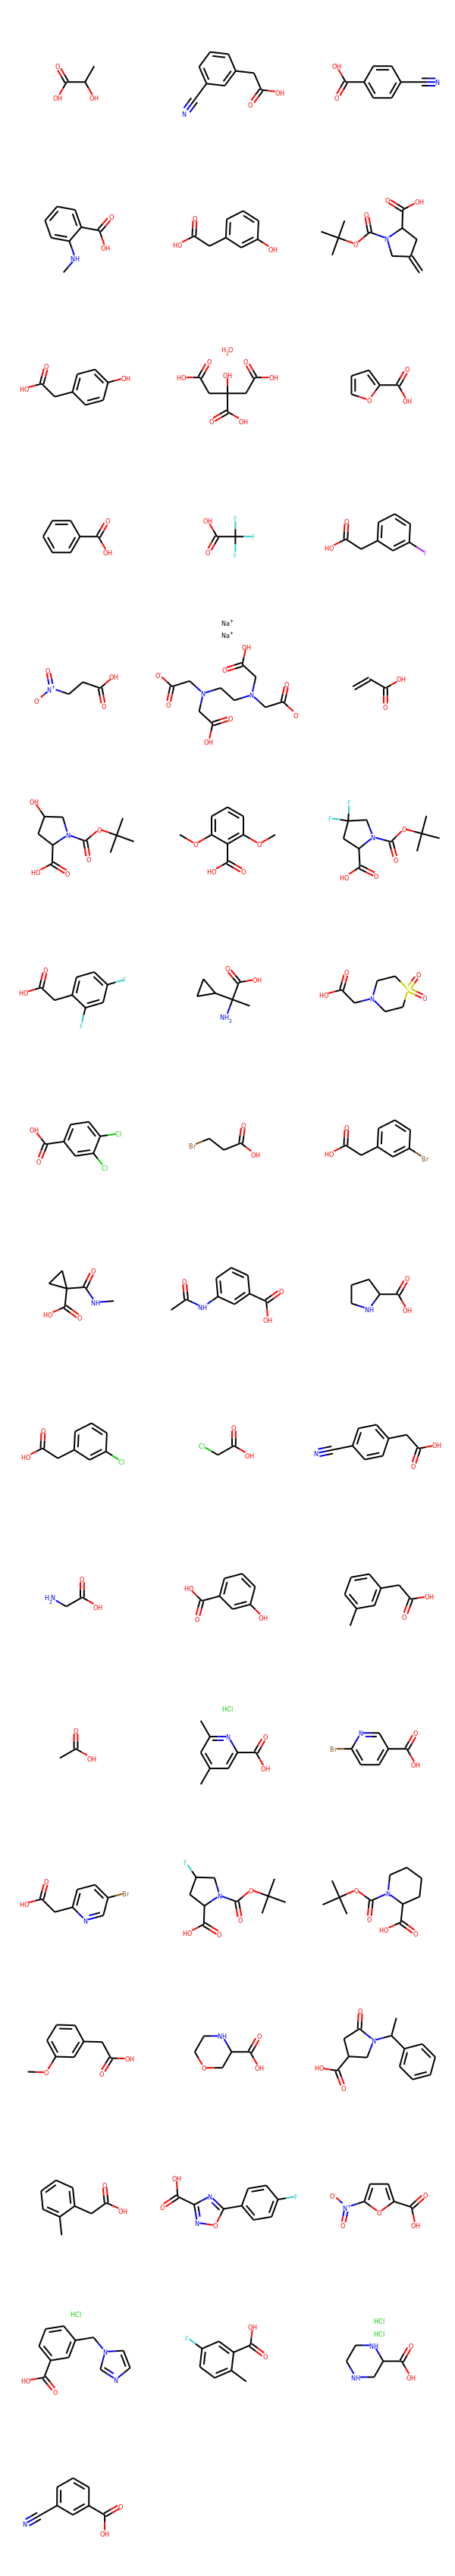

In [7]:
# For sanity check - let's see what the compounds are? 
# Change function call to see RCOOH_mols, RCOCl_mols and/or RNH2_mols
# Need to go through with Anthony to sanity check for ones we do not want
# to use

# The RCOOH reacts
Draw.MolsToGridImage(RCOOH_mols)

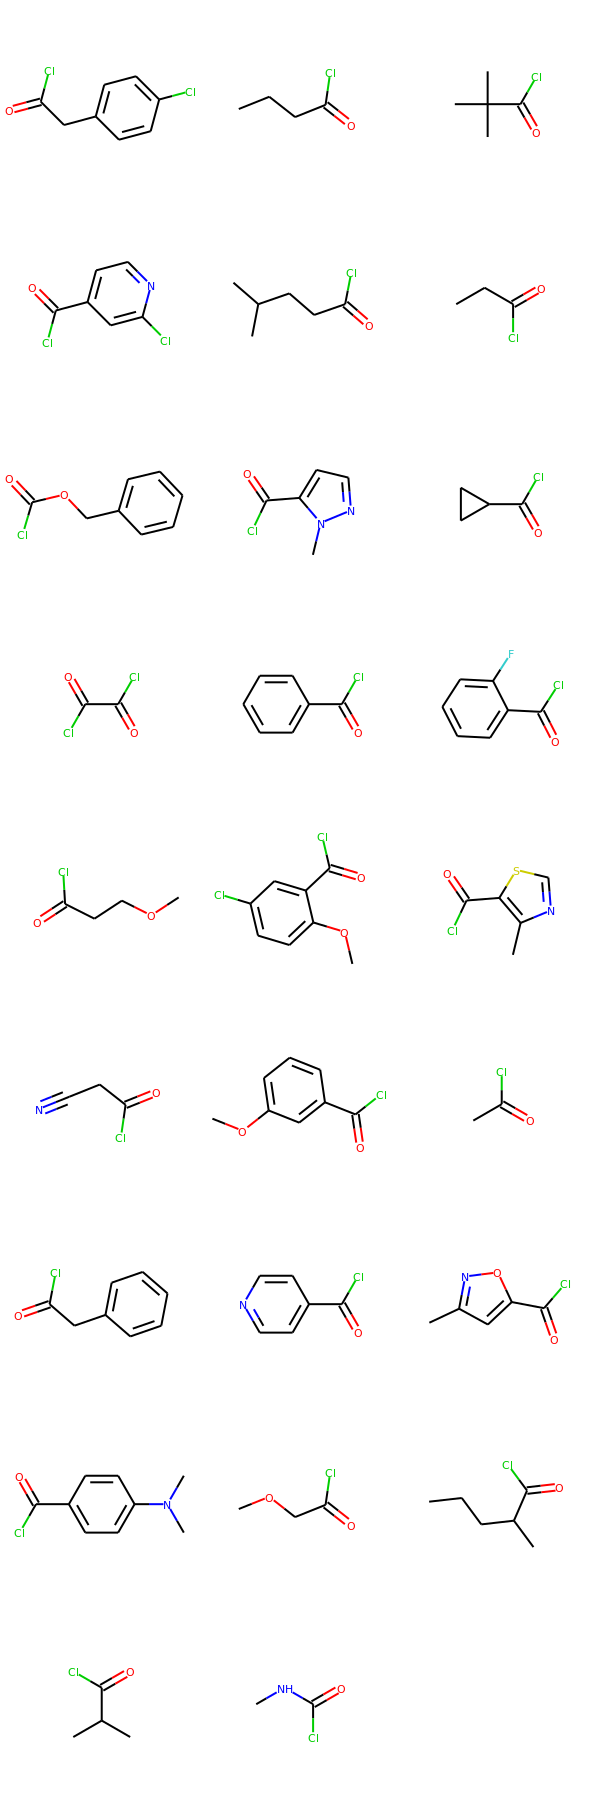

In [8]:
# The RCOCl reacts
Draw.MolsToGridImage(RCOCl_mols)

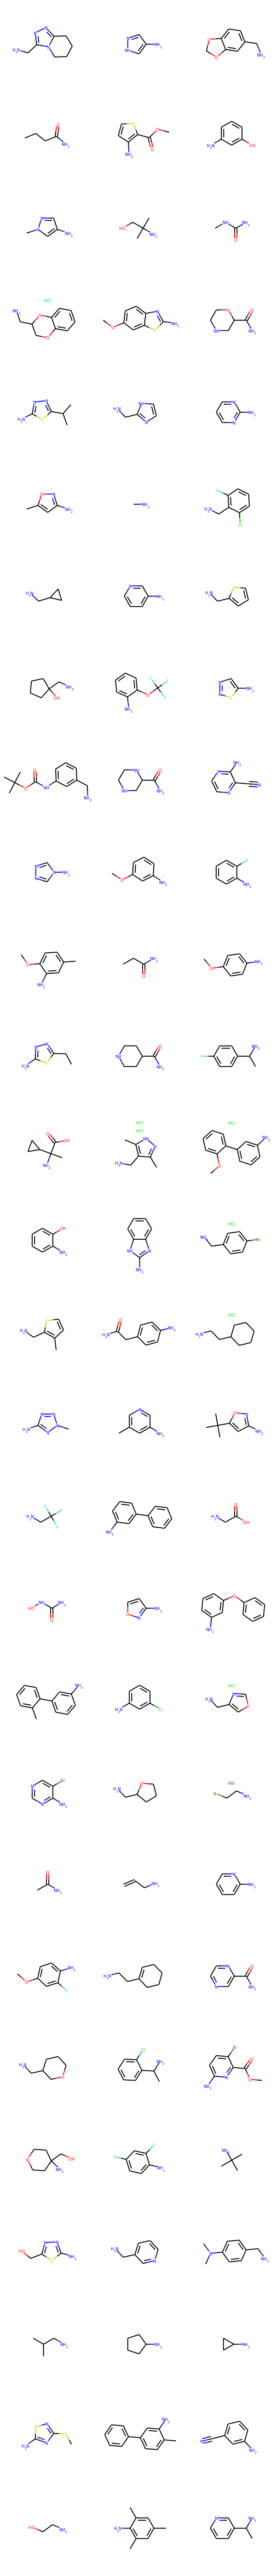

In [9]:
# The RNH2 reacts
Draw.MolsToGridImage(RNH2_mols)

In [10]:
# let's now get the prods of the amide coupling reaction
RCOOH_RNH2_prods, RCOCl_RNH2_prods = reactamide(RCOOH_mols, RCOCl_mols, RNH2_mols)

In [11]:
# How many products di we get?
print("No RCOOH + RNH2 products: {}\nNo RCOCl + RNH2 products: {}".format(len(RCOOH_RNH2_prods), len(RCOCl_RNH2_prods)))

No RCOOH + RNH2 products: 4116
No RCOCl + RNH2 products: 2184


In [12]:
# What do the products look like? 
# Drawing large number of compounds does not work too well here. May need to edit no
# compounds or change image size settings
# Draw.MolsToGridImage(RCOOH_RNH2_prods[0:100])  

# Uncomment line and edit above to save figures:
# 'img = Draw.MolsToGridImage(RCOOH_RNH2_prods[0:300],molsPerRow=3,subImgSize=(500,500))'

#img.save('/home/warren/XChem_projects/xchem-CovidOT/images/RCOOH_RNH2_prods_0_1000.png') 

In [13]:
# Create smiles lists of products
RCOOH_RNH2_prods_smiles = [Chem.MolToSmiles(mol) for mol in RCOOH_RNH2_prods]
RCOCl_RNH2_prods_smiles = [Chem.MolToSmiles(mol) for mol in RCOCl_RNH2_prods]

In [14]:
# Ok so we have a good few potential compounds with the reagents we have in stock. 
# Have any of these been made in the Covid Moonshot project? 
# Load CCD vault submissions
moonshot_cmps = pd.read_csv('/home/warren/XChem_projects/xchem-CovidOT/in_data/CDD_CSV_Export_2020-08-14.csv')

In [15]:
moonshot_cmps.head()

,Molecule Name,SMILES
0,CVD-0012807,OC(Cc1cccc(Cl)c1)Cn1cncn1
1,CVD-0012806,Cc1cc2OCC(C(=O)N3CCCCC3c3cn[nH]c3)c2cc1C
2,CVD-0012805,COc1cccc(Oc2cc(Cl)cc(NC(=O)Cc3cncc4ccccc34)c2)n1
3,CVD-0012804,Clc1cccc(c1)C1CNC(=O)N(C1=O)c1cncc2ccccc12
4,CVD-0012803,Clc1cccc(c1)C1NC(=O)N(C1=O)c1cncc2ccccc12


In [16]:
# OK so turns out the CCD data export has some nasty empty string values for some rows...
# Let's drop these rows from our dataset by replacing the empty strings as NaN types and 
# then dropping NaN rows
moonshot_cmps['SMILES'].replace('', np.nan, inplace=True)
moonshot_cmps.dropna(subset=['SMILES'], inplace=True)

In [17]:
# Let's compare the Moonshot compounds vs our enumerated amide coupling compounds
# First let's make sure that the SMILES from CCD are in rdkit "version"
moonshot_cmps['SMILES'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in moonshot_cmps.SMILES]

In [18]:
# Remove matching smiles from our lists
RCOOH_RNH2_prods_matches = moonshot_cmps['SMILES'][moonshot_cmps['SMILES'].isin(RCOOH_RNH2_prods_smiles)]
RCOOH_RNH2_prods_matches = [smi for smi in RCOOH_RNH2_prods_matches]
RCOOH_RNH2_prods_mols = [Chem.MolFromSmiles(smi) for smi in RCOOH_RNH2_prods_smiles if smi not in RCOOH_RNH2_prods_matches]
RCOOH_RNH2_prods_mols = [mol for mol in RCOOH_RNH2_prods_mols if mol is not None]

RCOCl_RNH2_prods_matches = moonshot_cmps['SMILES'][moonshot_cmps['SMILES'].isin(RCOCl_RNH2_prods_smiles)]
RCOCl_RNH2_prods_matches = [smi for smi in RCOCl_RNH2_prods_matches] 
RCOCl_RNH2_prods_mols = [Chem.MolFromSmiles(smi) for smi in RCOCl_RNH2_prods_smiles if smi not in RCOCl_RNH2_prods_matches]
RCOCl_RNH2_prods_mols = [mol for mol in RCOCl_RNH2_prods_mols if mol is not None]

In [19]:
# How many compounds are in each list?
print("No filtered RCOOH + RNH2 products: {}\nNo filtered RCOCl + RNH2 products: {}".format(len(RCOOH_RNH2_prods_mols), 
                                                                                            len(RCOCl_RNH2_prods_mols)))

No filtered RCOOH + RNH2 products: 3961
No filtered RCOCl + RNH2 products: 2103


In [20]:
# Ok so we have some unique compounds but what about selecting best possible compounds?
# How about we use a fingerprint similarity search to select compounds that match top
# nM amide coupling like Moonshot project compounds?
ADA_UCB_6c2cb422_1 = Chem.MolFromSmiles('O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12') 
TRY_UNI_2eddb1ff_7  = Chem.MolFromSmiles('Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OC2CC(=O)N2)c1') 

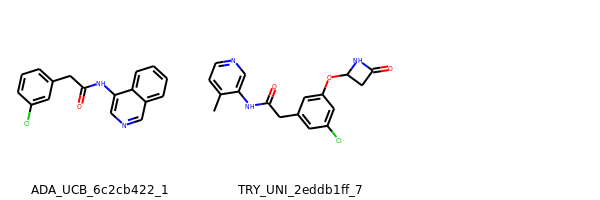

In [21]:
# What do these compounds look like?
Draw.MolsToGridImage([ADA_UCB_6c2cb422_1,TRY_UNI_2eddb1ff_7], 
                     legends=['ADA_UCB_6c2cb422_1','TRY_UNI_2eddb1ff_7'])

In [22]:
# Get the top scoring Moonshot compounds vector fingerprints
ADA_UCB_6c2cb422_1_fp = Chem.RDKFingerprint(ADA_UCB_6c2cb422_1)
TRY_UNI_2eddb1ff_7_fp = Chem.RDKFingerprint(TRY_UNI_2eddb1ff_7)

In [23]:
# Get fingerprint vectors for all enumerated compounds
RCOOH_RNH2_fps = [Chem.RDKFingerprint(mol) for mol in RCOOH_RNH2_prods_mols]
RCOCl_RNH2_fps = [Chem.RDKFingerprint(mol) for mol in RCOCl_RNH2_prods_mols]

In [24]:
# Get the similarity scores of RCOOH_RNH2 products vs ADA and TRY compounds
RCOOH_RNH2_ADA_smilarity = [DataStructs.FingerprintSimilarity(fp,ADA_UCB_6c2cb422_1_fp) for fp in RCOOH_RNH2_fps]
RCOOH_RNH2_TRY_smilarity = [DataStructs.FingerprintSimilarity(fp,TRY_UNI_2eddb1ff_7_fp) for fp in RCOOH_RNH2_fps]

(array([2.020e+02, 5.490e+02, 1.315e+03, 1.399e+03, 2.320e+02, 2.080e+02,
        2.300e+01, 2.100e+01, 1.100e+01, 1.000e+00]),
 array([0.02982456, 0.09263158, 0.1554386 , 0.21824561, 0.28105263,
        0.34385965, 0.40666667, 0.46947368, 0.5322807 , 0.59508772,
        0.65789474]),
 <BarContainer object of 10 artists>)

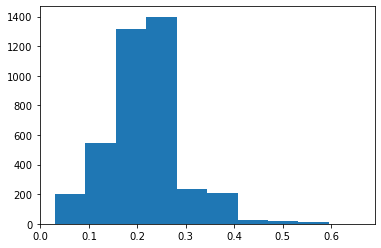

In [25]:
# Let's plot the results to get an idea of what the disctribution of scores are like
import matplotlib.pyplot as plt
plt.hist(RCOOH_RNH2_ADA_smilarity)

(array([ 111.,  295.,  526., 1332., 1106.,  401.,  131.,   51.,    3.,
           5.]),
 array([0.02925532, 0.08337766, 0.1375    , 0.19162234, 0.24574468,
        0.29986702, 0.35398936, 0.4081117 , 0.46223404, 0.51635638,
        0.57047872]),
 <BarContainer object of 10 artists>)

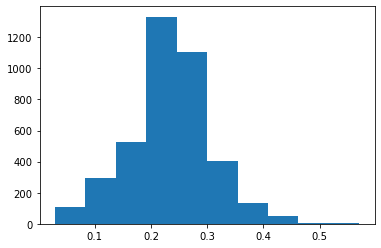

In [26]:
plt.hist(RCOOH_RNH2_TRY_smilarity)

In [27]:
# What do the top similarity compounds look like? Let's try filter our enumerated prods
# a bit. 
# First get indices of values above a theshold
RCOOH_RH2_ADA_indices = [index for index, similarity in enumerate(RCOOH_RNH2_ADA_smilarity) if similarity > 0.35]
RCOOH_RH2_TRY_indices = [index for index, similarity in enumerate(RCOOH_RNH2_TRY_smilarity) if similarity > 0.35]

In [28]:
# Now see what these mols look like by filtering using these indices
RCOOH_RNH2_ADA_filt_mols = [RCOOH_RNH2_prods_mols[index] for index in RCOOH_RH2_ADA_indices]
RCOOH_RNH2_TRY_filt_mols = [RCOOH_RNH2_prods_mols[index] for index in RCOOH_RH2_TRY_indices]

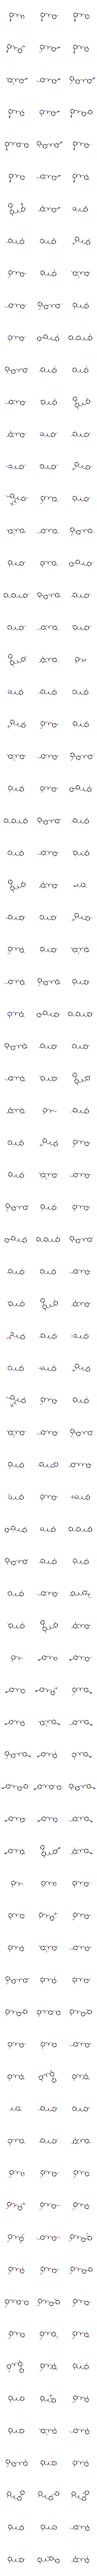

In [29]:
# Draw the ADA similarity molecules
Draw.MolsToGridImage(RCOOH_RNH2_ADA_filt_mols)

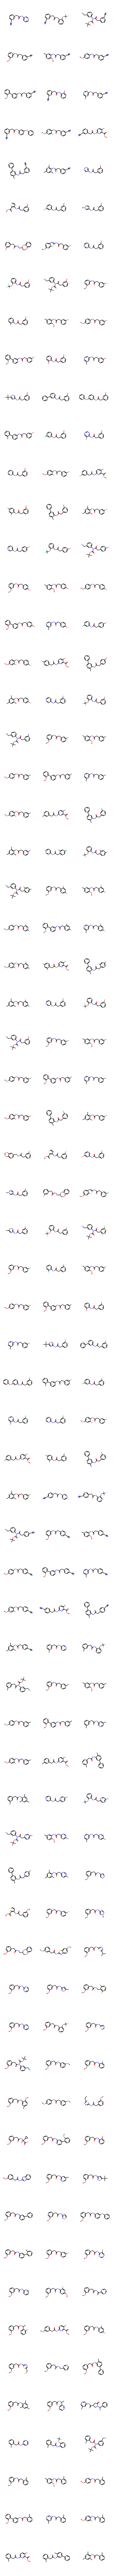

In [30]:
# Draw the TRY similarity molecules
Draw.MolsToGridImage(RCOOH_RNH2_TRY_filt_mols)